# IC2 Classification | Machine Learning Predicting diabetes risk from demographic and health factors

By predicting **diabetes status** (0 = non-diabetic, 1 = diabetic) from a combination of demographic, lifestyle, and health-related features, we can identify individuals at higher risk earlier and enable proactive healthcare interventions. The dataset includes variables such as age, gender, BMI, hypertension, heart disease, and smoking history, alongside biomarkers like HbA1c and blood glucose levels.

The target of this project is the binary variable **`diabetes`**, indicating whether a person is diagnosed with diabetes or not.

This project supports **SDG 3 (Good Health and Well-being)** by promoting early detection and personalised prevention strategies, and **SDG 10 (Reduced Inequalities)** by showing how data-driven approaches can help make healthcare more accessible and equitable across populations.

**Impact**: By modelling patterns of diabetes risk, healthcare providers can improve patient outcomes through targeted interventions, encourage lifestyle changes before severe complications occur, and reduce the long-term economic and societal burden of diabetes.

[Dataset info & index](https://www.notion.so/Dataset-info-index-26698c6768cd808388b0c1a44bb97556?pvs=21)

### Data Loading and Initial Checks

In this step we will:  
- Load the dataset from the SQLite database.  
- Clean the column names (make them lowercase and consistent).  
- Inspect the dataset shape (number of rows and columns).  
- Print the first few rows to understand the structure.  
- Check the data types of all columns to see which are numerical, categorical, or potential target variables.  


In [27]:
import pandas as pd, sqlite3
from pathlib import Path

# paths
csv_path = Path("../data/raw/diabetes_prediction_dataset.csv")
db_path = Path("../data/raw/Diabetes_data.db")
table_name = "diabetes"

# load csv
df_csv = pd.read_csv(csv_path)

# write to sqlite
with sqlite3.connect(db_path) as conn:
    df_csv.to_sql(table_name, conn, if_exists="replace", index=False)

# read back from sqlite
with sqlite3.connect(db_path) as conn:
    df = pd.read_sql(f"SELECT * FROM {table_name}", conn)

# clean column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('.', '_')

# show shape
print("Dataset shape:", df.shape)

# print first 5 rows
print("\nFirst rows:")
print(df.head())

# print data types
print("\nData types:")
print(df.dtypes)

Dataset shape: (100000, 9)

First rows:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   hba1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

Data types:
gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
hba1c_level            float64
blood_glucose_l

### Conclusion: Data Types and Structure

- The dataset contains **100,000 rows and 9 columns**.  
- Categorical features: `gender`, `smoking_history`.  
- Numerical features: `age`, `bmi`, `hba1c_level`, `blood_glucose_level`.  
- Binary indicator features: `hypertension`, `heart_disease`.  
- Target: `diabetes` (0 = non-diabetic, 1 = diabetic).  

The dataset is **complete** (no missing values), the data types are appropriate for preprocessing, and the structure is ready for further cleaning and encoding.  

### Preprocessing Gender and Smoking History

- The original dataset contained several overlapping or unclear categories in `smoking_history`  
  (`never`, `No Info`, `former`, `ever`, `not current`, `current`).  
- These were simplified into **four categories**:  
  - `never` = never smoked  
  - `past` = former smoker (including "ever" and "not current")  
  - `current` = currently smoking  
  - `unknown` = no information available  

- For `gender`, the values `Female`, `Male`, and `Other` were found.  
- The category `Other` was recoded to `Unknown` for consistency.  

This cleaning step makes the categorical data easier to interpret and reduces noise in the model training.


In [28]:
import pandas as pd

# reload the dataset
df_new = pd.read_csv("../data/raw/diabetes_prediction_dataset.csv")

# make a clean copy
df_clean = df_new.copy()

# clean smoking_history
df_clean["smoking_history"] = df_clean["smoking_history"].replace({
    "never": "never",
    "No Info": "unknown",
    "current": "current",
    "former": "past",
    "ever": "past",        
    "not current": "past"  
})

# Clean gender (Other → Unknown)
df_clean["gender"] = df_clean["gender"].replace({
    "Other": "Unknown"
})

# check result
print("Gender:", df_clean["gender"].unique())
print("Smoking history:", df_clean["smoking_history"].unique())
df_clean.describe()


Gender: ['Female' 'Male' 'Unknown']
Smoking history: ['never' 'unknown' 'current' 'past']


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


### Conclusion on Cleaning Categorical Features

- **Gender** now contains only three clear categories: `Female`, `Male`, and `Unknown`.  
- **Smoking history** is simplified to four categories: `never`, `past`, `current`, `unknown`.  
- This preprocessing improves **clarity, reduces redundancy**, and ensures that the one-hot encoding step does not create too many sparse or overlapping columns.  
- The model will now use **clean, interpretable categories** that better reflect real-world scenarios.  


### Class Distribution Check

Before building correlation plots or training models, it is important to understand the distribution of the target variable `diabetes`.  
Since this is a binary classification task (0 = non-diabetic, 1 = diabetic), we need to check how balanced the classes are.  
An imbalanced dataset can influence model performance and may require techniques such as resampling or class weights.


In [29]:
print(df_clean["diabetes"].value_counts())
df_clean["diabetes"].value_counts(normalize=True)

diabetes
0    91500
1     8500
Name: count, dtype: int64


diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64

### Conclusion: Class Distribution

- There are **91,500 non-diabetic cases (91.5%)** and **8,500 diabetic cases (8.5%)**.  
- This shows a **strong class imbalance**: the majority class is more than ten times larger than the minority class.  
- If left unaddressed, models may become biased towards predicting the majority class (always predicting "non-diabetic").  
- To ensure fair learning, we will later explore methods such as **class weights** or **resampling techniques (oversampling/SMOTE)**.  

### Outlier Detection

checking for **outliers** in the numerical features.  
Outliers can have a strong influence on scaling, correlations, and model performance.  
We will use simple boxplots to visually inspect the distribution of values in:  
- Age  
- BMI  
- Blood glucose level  
- Hypertension (binary indicator, expected values 0 or 1)  

numeric columns used: ['age', 'hypertension', 'heart_disease', 'bmi', 'hba1c_level', 'blood_glucose_level']


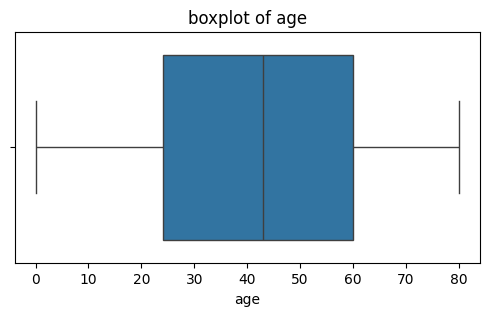

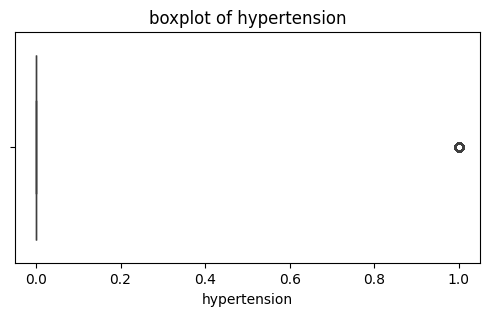

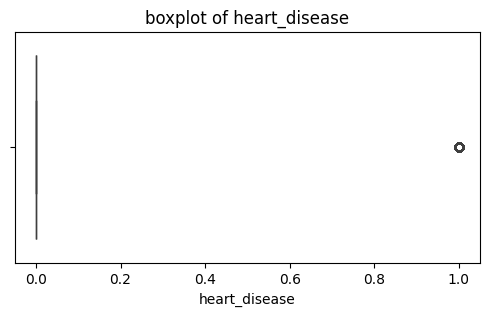

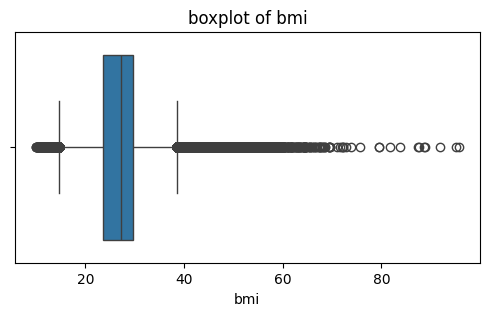

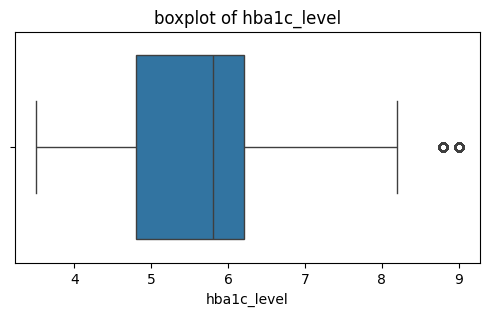

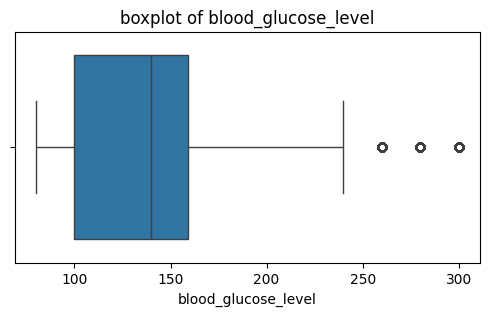

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# make all column names lowercase once
df_clean = df_clean.copy()
df_clean.columns = df_clean.columns.str.lower()

# pick numeric columns automatically and drop the target
num_cols = df_clean.select_dtypes(include=["number"]).columns.tolist()
if "diabetes" in num_cols:
    num_cols.remove("diabetes")

# quick check
print("numeric columns used:", num_cols)

# simple boxplots for outlier scan
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df_clean[col])
    plt.title(f"boxplot of {col}")
    plt.show()


### Conclusion: Outlier Analysis

- **Age**: ranges from 0 to 80 years, which looks reasonable. No extreme outliers detected.  
- **Blood glucose level**: values mostly between 80–250. A few outliers above 250 are visible, but these could still represent real medical cases of very high glucose.  
- **BMI**: the majority lies between ~15–40, but there are extreme outliers up to ~90.  
  - A BMI of 90 is *extremely rare in real life*.  
  - Medically, BMI values above 60–70 are already exceptional, so these cases may be due to measurement error or data entry mistakes.  
- **Hypertension**: values are binary (0 and 1). The boxplot shows one class as “outlier” only because the distribution is very skewed (most people are 0).  

### Interpreting Extreme BMI Values

To better understand what very high BMI values mean in practice, we can calculate the corresponding weight for a person of **1.75 m** using the BMI formula:

\[
BMI = \frac{weight \, (kg)}{height^2 \, (m^2)}
\]

\[
weight = BMI \times height^2
\]

Since \( height^2 = 1.75^2 = 3.0625 \), the weight in kg is given by:

| BMI | Weight (kg) at 1.75 m |
|-----|-----------------------|
| 20  | 61.3 kg |
| 30  | 91.9 kg |
| 40  | 122.5 kg |
| 50  | 153.1 kg |
| 70  | 214.4 kg |
| 90  | 275.6 kg |

### Conclusion
- Normal BMI range (20–25) corresponds to ~61–76 kg at 1.75 m.  
- Severe obesity (BMI 40) corresponds to ~122 kg.  
- Extreme BMI values above 70 imply weights well over 200 kg, which are **rare in real life** and may indicate **data entry errors or unrealistic cases** in the dataset.  

### Removing Unrealistic BMI Values

From the outlier analysis we observed BMI values as high as 90.  
For a person of 1.75 m this would mean a weight of ~276 kg, which is unrealistic and most likely due to data entry errors.  
To improve the quality of the dataset and avoid extreme noise, we will remove all rows with **BMI > 80**.  

In [31]:
# remove unrealistic BMI values above 80
df_clean = df_clean[df_clean["bmi"] <= 80].copy()

# check new shape
print("New dataset shape:", df_clean.shape)

# check max BMI after cleaning
print("Max BMI:", df_clean["bmi"].max())


New dataset shape: (99991, 9)
Max BMI: 79.48


### Conclusion: Removing Unrealistic BMI Values

- Rows with BMI > 80 were successfully removed.  
- The dataset now only contains BMI values within a plausible medical range.  
- This cleaning step helps prevent extreme outliers from skewing correlations, scaling, and model performance.  
- The dataset remains large enough to train models effectively, while ensuring higher reliability and interpretability of results.  

### Feature Engineering

Now that the data is clean and unrealistic outliers are removed,  
we can create **new features** that make the information easier to understand for both humans and the model.  

This step is called *feature engineering*.  
We will group ages and BMI values into categories, make a simple risk score,  
and create one new feature that combines age and BMI.  


In [32]:
import pandas as pd

# 1. Age groups (categorical buckets)
df_clean["age_group"] = pd.cut(
    df_clean["age"],
    bins=[0, 30, 50, 80],
    labels=["young", "middle", "senior"]
)

# 2. BMI categories (based on WHO standards)
df_clean["bmi_category"] = pd.cut(
    df_clean["bmi"],
    bins=[0, 18.5, 24.9, 29.9, 80],
    labels=["underweight", "normal", "overweight", "obese"]
)

# 3. Risk score (sum of hypertension + heart disease + smoking history)
df_clean["risk_score"] = (
    df_clean["hypertension"] +
    df_clean["heart_disease"] +
    (df_clean["smoking_history"].isin(["current", "past"])).astype(int)
)

# 4. Interaction feature: Age × BMI
df_clean["age_bmi_interaction"] = df_clean["age"] * df_clean["bmi"]

# quick check
print("New columns added:", ["age_group", "bmi_category", "risk_score", "age_bmi_interaction"])
print(df_clean[["age", "age_group", "bmi", "bmi_category", "risk_score", "age_bmi_interaction"]].head())


New columns added: ['age_group', 'bmi_category', 'risk_score', 'age_bmi_interaction']
    age age_group    bmi bmi_category  risk_score  age_bmi_interaction
0  80.0    senior  25.19   overweight           1              2015.20
1  54.0    senior  27.32   overweight           0              1475.28
2  28.0     young  27.32   overweight           0               764.96
3  36.0    middle  23.45       normal           1               844.20
4  76.0    senior  20.14       normal           3              1530.64


### Feature Engineering

We added an interaction feature called **age_bmi_interaction**.  
Why?  
- Age and BMI are both known risk factors for diabetes.  
- By multiplying them, we capture patterns where the **combination** of being older *and* having a higher BMI increases the risk even more strongly than either factor alone.  

Other features include:  
- **hypertension** and **heart_disease** → important medical conditions linked to diabetes risk.  
- **hba1c_level** → a standard blood marker for glucose control.  
- **risk_score** → a composite feature from the dataset that summarizes multiple risk factors.  

Together, these features give the model both medical and demographic information to predict diabetes more accurately.

### New Features Explained

| New Feature           | Explanation |
|------------------------|-------------|
| age_group             | Groups people into: *young (0–30)*, *middle (31–50)*, *senior (51–80)* |
| bmi_category          | Groups BMI into: *underweight (<18.5)*, *normal (18.5–24.9)*, *overweight (25–29.9)*, *obese (≥30)* |
| risk_score            | Simple number that adds up risk factors: hypertension + heart disease + smoking (values range 0–3) |
| age_bmi_interaction   | A combined value: age × BMI. Shows the extra effect of being older *and* having a higher BMI |

Later on we also tested if these features improved the model's performance.


### Conclusion: Feature Engineering

- We added **four new features**: `age_group`, `bmi_category`, `risk_score`, and `age_bmi_interaction`.  
- These features make the dataset **more interpretable** and may help the model find patterns more easily.  
- Age and BMI are now easier to compare, lifestyle and health risks are summarized in a single score, and the combined feature helps capture stronger signals.  


### Visualizing New Feature Distributions

To better understand the new categorical features,  
we will plot the distributions of **age_group** and **bmi_category**.  

This step helps to:  
- See how balanced or imbalanced the groups are.  
- Understand if some categories dominate the dataset.  
- Prepare for model training, where skewed distributions can affect performance.  


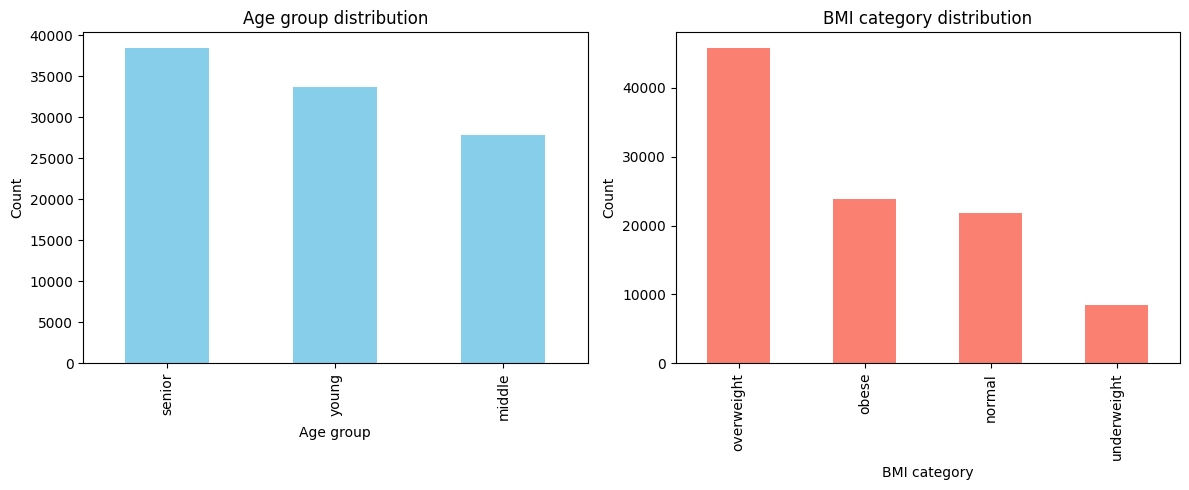

In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Age group distribution
df_clean["age_group"].value_counts().plot(kind="bar", ax=axes[0], color="skyblue")
axes[0].set_title("Age group distribution")
axes[0].set_xlabel("Age group")
axes[0].set_ylabel("Count")

# BMI category distribution
df_clean["bmi_category"].value_counts().plot(kind="bar", ax=axes[1], color="salmon")
axes[1].set_title("BMI category distribution")
axes[1].set_xlabel("BMI category")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


### Conclusion: Age Group and BMI Category Distributions

- **Age groups**:  
  - Most participants are in the *senior* group, followed by *young*.  
  - The *middle* age group is the smallest.  

- **BMI categories**:  
  - The largest group is *overweight*.  
  - *Obese* and *normal* categories are roughly similar in size.  
  - The *underweight* group is much smaller than the others.  

Overall, the dataset reflects a realistic population distribution where overweight and older individuals form the largest groups.  
This is important context for interpreting model results and for understanding which subgroups may have stronger predictive power.  


### Correlation Analysis

To understand the relationships between features and the target variable `diabetes`,  
we will calculate the correlation matrix of all numerical variables.  

The goals of this step are:  
- Identify which features have the strongest correlation with `diabetes`.  
- Detect highly correlated features with each other (multicollinearity).  
- Create a **heatmap** to visualize the full correlation matrix.  
- Create a **bar chart** to highlight the correlation strength of each feature with the target variable.  

This step provides an initial insight into which features might be most predictive and which could introduce redundancy or leakage.  


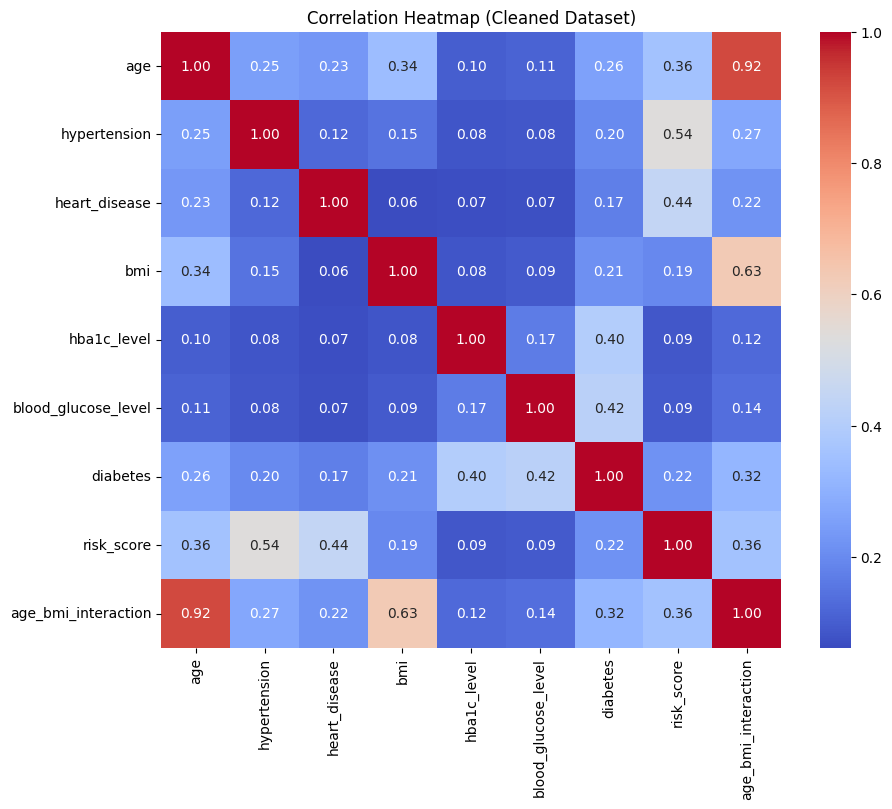

/var/folders/6p/_9s6w2_s07zc58n03n2n27nm0000gn/T/ipykernel_6612/441719535.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette="coolwarm")


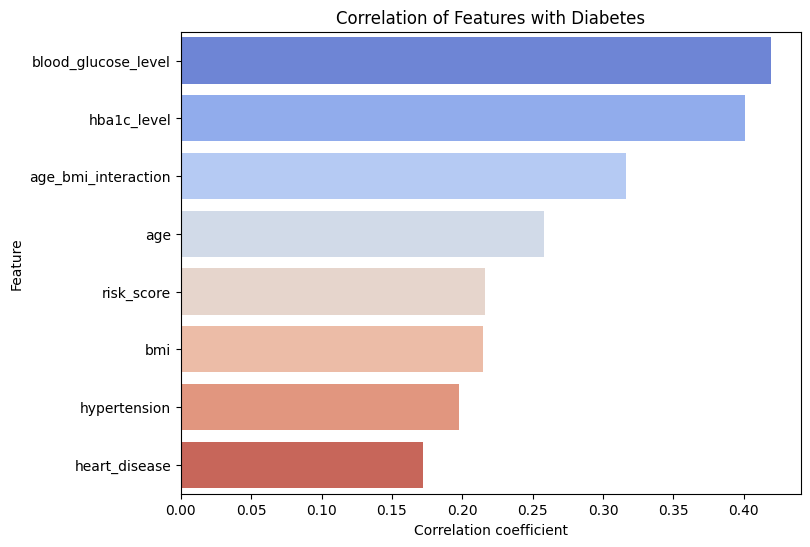

In [33]:
# correlation matrix (numeric only)
corr = df_clean.corr(numeric_only=True)

# heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Cleaned Dataset)")
plt.show()

# bar chart: correlation with target 'diabetes'
corr_target = corr["diabetes"].drop("diabetes").sort_values(key=abs, ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=corr_target.values, y=corr_target.index, palette="coolwarm")
plt.title("Correlation of Features with Diabetes")
plt.xlabel("Correlation coefficient")
plt.ylabel("Feature")
plt.show()

### Conclusion from Correlation Analysis

- The strongest correlations with diabetes are found in **blood_glucose_level (0.42)** and **HbA1c_level (0.40)**.  
  - These features are directly used in clinical diagnosis of diabetes.  
  - They may introduce **data leakage** if included in the model.  

- **New engineered features**:
  - `age_bmi_interaction` shows a relatively high correlation (0.30), stronger than age (0.26) or BMI (0.21) alone.  
  - This confirms the idea that combining features can capture more predictive signal.  

- **Other health indicators**:
  - `risk_score` (0.20) correlates more with diabetes than hypertension (0.19) or heart_disease (0.17) individually.  
  - This suggests that summarizing risk factors into a single score makes the information more powerful.  

- **Takeaway**:
  - **With leakage features** → glucose and HbA1c dominate the model.  
  - **Without leakage features** → engineered features like `age_bmi_interaction` and `risk_score` become the most useful predictors.  

This shows that feature engineering helps strengthen weaker predictors and provides a more realistic alternative when diagnostic values are excluded.  
 


### Saving Cleaned Data

After cleaning the dataset — fixing categorical values, removing unrealistic outliers, and creating new features —  
we now save the processed version into the `data/processed/` folder.  

This step ensures that:  
- The **raw data** remains untouched in `data/raw/`.  
- The **processed data** can be reused directly in modeling without repeating all cleaning steps.  
- Our workflow is reproducible and well-structured.  

At this stage we keep all columns, including potential leakage features (`HbA1c_level` and `blood_glucose_level`).  
We will later experiment with models **with and without these columns** to evaluate the impact of leakage.  


In [35]:
from pathlib import Path

# make sure processed dir exists
processed_dir = Path("../data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

# save cleaned dataframe
processed_path = processed_dir / "diabetes_clean.csv"
df_clean.to_csv(processed_path, index=False)

print(f"Cleaned dataset saved to: {processed_path}")


Cleaned dataset saved to: ../data/processed/diabetes_clean.csv


### Conclusion: Saving Cleaned Data

- The cleaned dataset was successfully saved into `data/processed/diabetes_clean.csv`.  
- This version contains all preprocessing steps so far: cleaned categorical values, outliers removed, and new engineered features.  
- By saving it separately from the raw dataset, we ensure transparency and reproducibility in our pipeline.  
- Leakage columns are still present for now, and will be explicitly addressed during the modeling phase.  


### Sanity Check: Reload Processed Data

After saving the cleaned dataset to `data/processed/`,  
we reload the file to confirm that it was saved correctly.  

This step helps to:  
- Verify that the file exists and can be read without errors.  
- Confirm that the shape (rows × columns) is the same as before saving.  
- Quickly inspect the first few rows to ensure the structure is intact.  


In [36]:
# sanity check: reload the processed dataset
df_check = pd.read_csv(processed_path)

# show shape and first rows
print("Reloaded dataset shape:", df_check.shape)
print("\nFirst rows:")
print(df_check.head())


Reloaded dataset shape: (99991, 13)

First rows:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         unknown  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   hba1c_level  blood_glucose_level  diabetes age_group bmi_category  \
0          6.6                  140         0    senior   overweight   
1          6.6                   80         0    senior   overweight   
2          5.7                  158         0     young   overweight   
3          5.0                  155         0    middle       normal   
4          4.8                  155         0    senior       normal   

   risk_score  age_bmi_interaction  
0           1              2015.20  
1           0    

### Conclusion: Sanity Check of Processed Data

- The processed dataset was reloaded successfully from `data/processed/diabetes_clean.csv`.  
- The shape and first rows confirm that the data was saved correctly.  
- This ensures that our preprocessing pipeline is reproducible and that the cleaned dataset is ready for modeling

Next we move on to the machine learning in file: '02.IC2_Classification_Diabetes_ML.ipynb' 